# MAPseq figures for Figure 3
- note figures were beatuified in Adobe Illustrator, so aethetics of the figures may look different in the manuscript, but data in plots are identical

In [ ]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF # for generating empirical cdfs
import matplotlib.lines as mlines # needed for custom legend
from matplotlib.colors import LogNorm # needed to plot heatmap on log scale
import os


# needed for editable text in svg format
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['text.usetex'] = False
plt.rcParams['svg.fonttype'] = 'none'

# load metadata
metadata = pd.read_csv("metadata.csv")

# import custom colormaps
from colormaps import blue_cmp, orange_cmp
# specify blue/orange colors for qualitative intervals/data
blue_qual = [blue_cmp.colors[50], blue_cmp.colors[100], blue_cmp.colors[150], blue_cmp.colors[200], blue_cmp.colors[250]]
orange_qual = [orange_cmp.colors[36], orange_cmp.colors[72], orange_cmp.colors[108], orange_cmp.colors[144], orange_cmp.colors[180], orange_cmp.colors[216], orange_cmp.colors[252]]


%matplotlib inline

# Load data

In [ ]:
# set-up out path
out_path = '/your/path/here/'

In [ ]:
# load metadata
meta_path = '/your/path/here/'
metadata = pd.read_csv(os.path.join(meta_path, "metadata.csv"))
metadata

,mice,species,sex,dataset
0,MMM1,MMus,male,M194
1,MMF2,MMus,female,M194
2,MMF3,MMus,female,M194
3,STM1,STeg,male,M194
4,STM2,STeg,male,M194
5,STF3,STeg,female,M194
6,MMM4,MMus,male,M220
7,MMF5,MMus,female,M220
8,STF4,STeg,female,M220
9,STM5,STeg,male,M220


In [ ]:
# load data

in_path = '/your/path/here/'

# load binarized data
omc_bin = []
for idx, row in metadata.iterrows():
    df = pd.read_csv(os.path.join(in_path, row["mice"]+"_"+row["dataset"]+"_bin.csv"), index_col=0)
    omc_bin.append(df)

omc_countN = []
for idx, row in metadata.iterrows():
    df = pd.read_csv(os.path.join(in_path, row["mice"]+"_"+row["dataset"]+"_countN.csv"), index_col=0)
    omc_countN.append(df)


# Functions

## Processing functions

In [10]:
def clean_up_data(df_dirty, to_drop = ['OB', 'ACAi', 'ACAc', 'HIP'], inj_site="OMCi"):
    """Clean up datasets so all matrices are in the same format. Function 
        (1) drops unwanted columns, e.g. negative controls or dissections of other injection sites. 
        (2) renames RN (allen acronym) as BS (my brainstem acronym)
        (3) drops neurons w/ 0 projections after dropped columns

    Args:
        df_dirty (DataFrame): Pandas dataframe (neurons x area) that needs to be processed
        to_drop (list, optional): columns to drop. Defaults to ['OB', 'ACAi', 'ACAc', 'HIP'].
        inj_site (str, optional): Injection site. Defaults to "OMCi".

    Returns:
        DataFrame: Cleaned up data in dataframe format.
    """

    # 1. drop unused areas
    dropped = df_dirty.drop(to_drop, axis=1)

    # 2. change RN to bs
    replaced = dropped.rename(columns={'RN':'BS'})

    # 3. drop neurons w/ 0 projections after removing negative regions
    if type(inj_site)==str:
        nodes = replaced.drop([inj_site], axis=1).sum(axis=1)
    else:
        nodes = replaced.drop(inj_site, axis=1).sum(axis=1)
    
    n_idx = nodes > 0 # non-zero projecting neurons
    clean = replaced[n_idx]
    
    return clean



In [11]:
def sort_by_celltype(proj, it_areas=["OMCc", "AUD", "STR"], ct_areas=["TH"],
                      pt_areas=["AMY","HY","SNr","SCm","PG","PAG","BS"],
                      sort=True):
    """
    Function takes in projection matrix and outputs matrix sorted by the 3 major celltypes:
    - IT = intratelencephalic (projects to cortical and/or Striatum), type = 10
    - CT = corticalthalamic (projects to thalamus w/o projection to brainstem), type = 100
    - PT = pyramidal tract (projects to brainstem += other areas), type = 1000
    Returns single dataframe with cells sorted and labelled by 3 cell types (IT/CT/PT)

    Args:
        proj (DataFrame): pd.DataFrame of BC x area. Entries can be normalized BC or binary.
        it_areas (list, optional): Areas to determine IT cells. Defaults to ["OMCc", "AUD", "STR"].
        ct_areas (list, optional): Areas to determine CT cells. Defaults to ["TH"]. Don't actually use this...
        pt_areas (list, optional): Areas to determine PT cells. Defaults to ["AMY","HY","SNr","SCm","PG","PAG","BS"].
        sort (bool, optional): Whether to sort by cell type or return w/ original index. Defaults to True.
    
    Returns:
        df_out (DataFrame): Returns dataframe with extra column (type) labelled and sorted by cell type
    """
    
    ds=proj.copy()
 
    # Isolate PT cells
    pt_counts = ds[pt_areas].sum(axis=1)
    pt_idx = ds[pt_counts>0].index
    ds_pt = ds.loc[pt_idx,:]
    ds_pt['type'] = "PT"

    # Isolate remaining non-PT cells
    ds_npt = ds.drop(pt_idx)

    # Identify CT cells by thalamus projection
    th_idx = ds_npt['TH'] > 0
    ds_th = ds_npt[th_idx]
    if sort:
        ds_th = ds_th.sort_values('TH', ascending=False)
    ds_th['type'] = "CT"

    # Identify IT cells by the remaining cells (non-PT, non-CT)
    ds_nth = ds_npt[~th_idx]
    if sort:
        ds_nth = ds_nth.sort_values(it_areas,ascending=False)
    ds_nth['type'] = "IT"

    # combine IT and CT cells
    ds_npt = pd.concat([ds_nth, ds_th])

    # combine IT/CT and PT cells
    if sort:
        sorted = pd.concat([ds_npt,ds_pt],ignore_index=True)
        df_out=sorted.reset_index(drop=True)
    else:
        df_out = pd.concat([ds_npt,ds_pt]).sort_index()

    return(df_out)



In [12]:
def dfs_preprocess_counts(df_list, drop=["type"], 
                          norm_by="inj_median", inj_site="OMCi", medians=None):
    """Take dataframe and process it for downstream analysis. Can be binarized or 
    non-binarized data.

    Args:
        df_list (list): List of dataframes, 
        drop (list, optional): List of columns to drop before returning. Defaults to ["OMCi", "type"].
        norm_by (str, optional): How to normalize counts. Can be "inj_median" or 'all_median' or "given". Defaults to "inj_median".
        inj_site (str, optional): What column to use for injection norm. Defaults to "OMCi".
        medians (list, optional): if norm_by=="given", uses list of medians (same length as df_list) to normalize dataframes. Defaults to None.

    Returns:
        out_list (list): List of dataframes same order as input list.
    """
    
    out_list = []
    norms_out = []
    for i in range(len(df_list)):
        df = df_list[i].drop(drop, axis=1)

        if norm_by=="inj_row":
            # normalize on neuron by neuron basis to injection site value
            out_df = df.div(df[inj_site], axis=0)
        elif norm_by=="given":
            out_df = df/medians[i]
        elif norm_by=="inj_mean":
            vals = df[inj_site].values.flatten()
            mean = np.mean(vals)
            norms_out.append(mean)
            out_df = df/mean
        else:
            # normalize by non-zero median of injection site
            if norm_by=="inj_median":
                vals = df[inj_site].values.flatten() # added injection site median
            # normalize by median of all non-zero values median across whole dataset
            elif norm_by=="all_median":
                vals = df.values.flatten()
            idx = vals.nonzero() # only use non-zero ncounts for determining median
            plot = vals[idx]
            median = np.median(plot)
            norms_out.append(median)
            out_df = df/median

        for j in range(len(drop)):
            out_df[drop[j]] = df_list[i][drop[j]] # add dropped columns back in, can preserve labels
        
        out_list.append(out_df)

    if len(norms_out)>0:
        return(norms_out, out_list)
    else:
        return(out_list)

In [13]:
def dfs_to_cdf(df_list, plot_areas, resolution=1000, metadata=metadata):
    """Takes in list of DFs of count(N) data and returns dataframe w/ cdf data that can be plotted.
    Returned Dataframe includes metadata

    Args:
        df_list (list): list of DataFrames of count(N) data.
        plot_areas (list): List of strings of areas to calculate cdfs.
        resolution (int, optional): Used to determine resolution of cdf line. Defaults to 1000.
        medatadata (df, optional): Metadata where row corresponds to df_list indices. Defaults to metadata.
    Returns:
        cdf_df (DataFrame): Dataframe of cdf summary values
        all_ecdfs (list): Empirical cdf 
    """

    # combine all DFs into one df labelled w/ metadata
    all_bc = pd.DataFrame(columns=list(df_list[0].columns)+["mice", "species", "dataset"])
    for i in range(metadata.shape[0]):
        df = df_list[i].copy(deep=True)
        df['mice'] = metadata.loc[i, 'mice']
        df['species'] = metadata.loc[i, "species"]
        df['dataset'] = metadata.loc[i, "dataset"]
        all_bc = pd.concat([all_bc, df])

    all_bc = all_bc.reset_index(drop=True)

    cdf_df = pd.DataFrame(columns=["x", "cdf", "mice", "species", "dataset", "area"])

    all_ecdfs = {}

    # calculate cdf by area, then add by mouse
    for area in plot_areas:
        # just use nonzero BC
        area_idx = all_bc[area] > 0
        area_bc = all_bc.loc[area_idx, [area, "mice", "species", "dataset"]]
        # get min/max for each area to set cdf bounds
        area_min = area_bc[area].min()
        area_max = area_bc[area].max()

        for i in range(metadata.shape[0]):
            micei = metadata.loc[i, 'mice']
            mice_bc = area_bc[area_bc['mice']==micei]
            if mice_bc[area].sum()==0:
                print("NO BARCODES, cannot compute ECDF for", area, metadata.loc[i,'mice'])
            else:
                # print(area, metadata.loc[i,"mice"])
                ecdf = ECDF(mice_bc[area])
                x = np.logspace(np.log10(area_min), np.log10(area_max), num=resolution)
                y = ecdf(x)

                int = pd.DataFrame({"x":x, "cdf":y, "mice":metadata.loc[i,"mice"], "species":metadata.loc[i,"species"], 
                                    "dataset":metadata.loc[i,"dataset"], "area":area})
                cdf_df = pd.concat([cdf_df, int])
                all_ecdfs[micei+"_"+area] = ecdf

    return(cdf_df, all_ecdfs)

In [14]:
def dfs_to_medians(df_list, drop=["AOMCi", "POMCi", "ACAi", "ACAc", "OB", "HIP", "inj_site", 
                                  'L1_ctl', 'H2O_inj_ctl', 'H2O_targ_ctl'], 
                   keep=None, cell_type=None, meta=metadata, inj_site="OMCi"):
    
    """Output dataframe of medians in format that can be plotted with seaborn"

    Args:
        df_list (list): 
            - List of dataframes (normalized counts) of neurons/BC by areas
        drop (list, optional): 
            - Defaults to ["AOMCi", "POMCi", "inj_site", 'L1_ctl', 'H2O_inj_ctl', 'H2O_targ_ctl']
            - list of areas/columns to drop before calculating proportions
        cell_type (string, optional): 
            - Specify cell types in df, either IT, CT or PT
            - Defaults to None

    Returns:
        plot_df (pandas_dataframe):
            - returns dataframe in format for seaborn plotting
            - columns = areas, and other metadata
    """

    plot_df = pd.DataFrame(columns=["area", "median", "mice", "species", "dataset"])

    if cell_type == "IT":
        drop = [inj_site, 'TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG',
       'PAG', 'BS']
    elif cell_type == "PT":
        drop = [inj_site,inj_site[:-1]+"c", 'AUD', "STR"]

    if keep:
        drop = []

    mice = meta["mice"]
    species = meta["species"]
    dataset = meta["dataset"]

    for i in range(len(df_list)):
        df = df_list[i].drop(drop, axis=1)
        if keep:
            df = df.loc[:, keep] # just subset keep columns

        # only keep nonzero BC to calculate median
        df.replace(0, np.nan, inplace=True)
        medians = df.median(axis=0)
        df_add = pd.DataFrame({"area":medians.index.values, "median":medians.values, 
        "mice":mice[i], "species":species[i], "dataset":dataset[i]})
        plot_df = pd.concat([plot_df, df_add])
    
    return(plot_df)

In [15]:
def dfs_to_proportions(df_list, drop=["OMCi", "type"], keep=None, cell_type=None, meta=metadata, 
                       inj_site="OMCi", aud_rename=False):
    """Output dataframe of proportions in format that can be plotted with seaborn

    Args:
        df_list (list): 
            - List of dataframes of neurons/BC by areas
        drop (list, optional): 
            - Defaults to ["OMCi", "type"]
            - list of areas/columns to drop before calculating proportions
        cell_type (string, optional): 
            - Specify cell types in df, either IT, CT or PT
            - Defaults to None

    Returns:
        plot_df (pandas_dataframe):
            - returns dataframe in format for seaborn plotting
            - columns = areas, and other metadata
    """

    plot_df = pd.DataFrame(columns=["area", "proportion", "mice", "species", "dataset"])

    if cell_type == "IT":
        drop.extend([inj_site, 'TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG',
       'PAG', 'BS'])
    elif cell_type == "PT":
        if aud_rename:
            drop.extend([inj_site,inj_site[:-1]+"c", 'AUD/TEa', "STR"])
        else:
            drop.extend([inj_site,inj_site[:-1]+"c", 'AUD', "STR"])

    if keep:
        drop = []

    mice = meta["mice"]
    species = meta["species"]
    dataset = meta["dataset"]

    for i in range(len(df_list)):
        df = df_list[i].drop(drop, axis=1)
        if keep:
            df = df.loc[:, keep] # just subset keep columns
        bc_sum = df.sum()
        proportion = bc_sum/df.shape[0]
        df_add = pd.DataFrame({"area":proportion.index.values, "proportion":proportion.values, 
        "mice":meta.loc[i,"mice"], "species":meta.loc[i,"species"], "dataset":meta.loc[i,"dataset"]})
        # add cell_type if specified
        if cell_type:
            df_add["type"] = cell_type
        plot_df = pd.concat([plot_df, df_add])
    
    return plot_df

In [16]:
def statistic_testing(df, sp1="MMus", sp2="STeg", to_plot='proportion', 
                     groupby="area", test="ttest"):
    """output dataframe based on comparison of species individuals
        output dataframe can be used for making volcano plot

    Args:
        df (DataFrame): DataFrame of repeated values across species and inviduals.
        sp1 (str, optional): Group1 to use as comparison. Defaults to "MMus".
        sp2 (str, optional): Group1 to use as comparison. Defaults to "STeg".
        to_plot (str, optional): Column to calculate comparison. Defaults to 'proportion'.
        groupby (str, optional): Categories within to do comparison. Defaults to "area".
        test (str, optional): What test to use ["ttest", "mannwhitneyu"]. Defaults to "ttest".
    Returns:
        plot (DataFrame): pd.DataFrame w/ pvalues, means across species, and log. Can be used for volcano plot.
    """

    groups = sorted(df[groupby].unique())

    # sp1
    sp1_df = df[df["species"]==sp1]
    sp1_array = sp1_df.pivot_table(columns='mice', values=to_plot, index=groupby).values

    sp2_df = df[df["species"]==sp2]
    sp2_array = sp2_df.pivot_table(columns='mice', values=to_plot, index=groupby).values

    if test=="ttest":
        results = stats.ttest_ind(sp1_array, sp2_array, axis=1)
    elif test=="mannwhitneyu":
        results = stats.mannwhitneyu(sp1_array, sp2_array, axis=1)
    
    p_vals = results[1]
    plot = pd.DataFrame({groupby:groups, "p-value":p_vals})
    plot[sp1+"_mean"] = sp1_array.mean(axis=1)
    plot[sp1+"_sem"] = stats.sem(sp1_array, axis=1)
    plot[sp2+"_mean"] = sp2_array.mean(axis=1)
    plot[sp2+"_sem"] = stats.sem(sp2_array, axis=1)
    # plot["effect_size"] = (plot["st_mean"]-plot["mm_mean"]) / (plot["st_mean"] + plot["mm_mean"]) # modulation index
    plot["fold_change"] = plot[sp2+"_mean"]/(plot[sp1+"_mean"])
    plot["log2_fc"] = np.log2(plot["fold_change"])
    plot["nlog10_p"] = -np.log10(plot["p-value"])
    plot["p<0.05"] = plot["p-value"]<0.05

    return(plot)

In [17]:
def stvmm_calc_ttest(data, sp1="MMus", sp2="STeg", to_plot='proportion',
                     groupby="area", test="ttest"):
    """Given dataset w/ labeled cell type and species, calculate  p-values b/w species replicates

    Args:
        df (DataFrame): DataFrame of repeated values across species and inviduals.
        sp1 (str, optional): Group1 to use as comparison. Defaults to "MMus".
        sp2 (str, optional): Group1 to use as comparison. Defaults to "STeg".
        to_plot (str, optional): Column to calculate comparison. Defaults to 'proportion'.
        groupby (str, optional): Categories within to do comparison. Defaults to "area".
        test (str, optional): What test to use ["ttest", "mannwhitneyu"]. Defaults to "ttest".
    Returns:
        plot (DataFrame): pd.DataFrame w/ pvalues, means across species, and log. Can be used for volcano plot.
    """

    # separate by cell type
    data_it = data[data["type"]=="IT"]
    data_pt = data[data["type"]=="PT"]

    it_tt = statistic_testing(data_it, sp1=sp1, sp2=sp2, to_plot=to_plot,
                             groupby=groupby, test=test)
    it_tt['type'] = "IT"
    pt_tt = statistic_testing(data_pt, sp1=sp1, sp2=sp2, to_plot=to_plot,
                             groupby=groupby, test=test)
    pt_tt['type'] = "PT"

    omc_tt = pd.concat([it_tt, pt_tt])
    omc_tt['p<0.05'] = omc_tt['p-value']<0.05
    omc_tt = omc_tt.reset_index(drop=True)
    
    return(omc_tt)

In [18]:
def downsample_neurons(data, meta=metadata, random_state=10, species="MMus", sample_ns=None):
    """Given list of dataframe, sample from combined neurons/cells (with replacement), in equivalent numbers
    to singing mouse (or sample_ns) cells/brain. Returns list where each element is dataframe of neurons w/ numbers equivalent to ns.

    Args:
        data (list): List of pandas dataframes where each row is a different cell/neuron
        metadata (DataFrame, optional): Metadata used to determine which df in data is lab/singing mouse. 
                                        Defaults to metadata.
        random_state (int, optional): Set random state to use for repeatable sampling.
                                        Defaults to 10.
        species (str, optional): Species to sample. Defaults to "MMus".
        sample_ns (list, optional): List of int use as sample size per 'brain', if none defaults to singing mouse brain size.
                                         Defaults to None.
    """

    all = [data[i] for i in range(metadata.shape[0]) if metadata.loc[i,'species']==species]
    all = pd.concat(all).reset_index(drop=True)

    # print("mm_all.shape[0]", mm_all.shape[0])
    pool = all.copy()
    samp = []

    ns = []
    if sample_ns:
        ns = sample_ns
    else:
        # get steg sample neuron sizes
        for i in range(metadata.shape[0]):
            if metadata.loc[i,'species']=="STeg":
                ns.append(data[i].shape[0])


    for i in range(len(ns)):
        n = ns[i]
        int = pool.sample(n, random_state=random_state+i) # can't have same random_state for every round or will sample the same neurons

        samp.append(int.reset_index(drop=True))

    return(samp)

## Plotting functions

In [27]:
def sorted_heatmap(df, title=None, sort_by=['type'], sort_ascend=True, drop=['type'], 
                   nsample=None, random_state=10, log=False, cmap=orange_cmp, cbar=False,
                   label_neurons=None, col_order=None, rasterized=True):
    """Plot sorted heatmap of normalized barcode counts.

    Args:
        df (DataFrame): Dataframe to plot heatmap
        sort_by (list, optional): How to sort neurons. Defaults to ['type'].
        sort_ascend (boolean, optional): whether to sort ascending or descending. Defaults to True.
        drop (list, optional): What columns to drop before plotting. Defaults to ['type'].
        nsample (int, optional): If present, down sample dataframe. Defaults to None.
        random_state (int, optional): If downsample, what random state to use. Defaults to 10.
        log (bool, optional): Whether to plot log scale. Defaults to None.
        cmap (colormap, optional): What colormap to use for plotting. Defaults orange_cmp.
        cbar (boolean, optional): Whether to plot cbar or not. Defaults to False.
        label_neurons (dict, option): Dictionary of label:index of neurons to label
        col_order (list, optional): Order to plot columns. Defaults to None.
        rasterized (boolean, optional): Wheter to rasterize plot. Defaults to True.

    Return:
        out_plot (DataFrame): Dataframe used to plot heatmap
        fig (plt.figure): figure plotted
    """

    if nsample:
        plot = df.sample(nsample, random_state=random_state)
    else:
        plot = df.copy()

    if log:
        plot = plot.replace({"IT":1, "CT":10, "PT":100})
        norm = LogNorm()
    else:
        plot = plot.replace({"IT":0.25, "CT":0.5, "PT":0.75})
        norm = None

    plot = plot.sort_values(by=sort_by, ascending=sort_ascend)
    plot = plot.reset_index(drop=True)
    out_plot = plot.copy()


    # reorder cols if given
    if col_order:
        plot = plot[col_order]

    fig=plt.subplot()
    sns.heatmap(plot.drop(drop, axis=1), norm=norm, cmap=cmap, cbar=cbar, rasterized=rasterized)
    plt.gca().get_yaxis().set_visible(False)
    plt.title(title)
    
    # optional
    if label_neurons:
        for key in label_neurons.keys():
            plt.text(-0.3,label_neurons[key], "-", va="center_baseline", size=15)
            plt.text(-0.75,label_neurons[key], key, va="center_baseline", size=12)
    return(out_plot, fig)

In [20]:
def dot_plot(data, subset=None, title=None, err="se", add_legend=False,
                              to_plot="proportion", ylim=(0), fig_size=(3.5,3.5),
                              jitter=False, alpha=0.3):
    """Plot closed circle of value per area for data.

    Args:
        data (DataFrame): Dataframe of proportions, included downsampled data.
        subset (list, optional): List of what to subset on to plot. Defaults to None.
        title (str, optional): Title for plot. Defaults to None.
        err (str, optional): Error to plot, can be "ci", "pi", "se", or "sd". Defaults to "se".
        add_legend (bool, optional): Whether to add legend labeling mean/err. Defaults to False.
        to_plot (str, optional): Column to plot. Defaults to "proportion".
        ylim (tuple, optional): lower bound for yaxis. Defaults to (0).
        fig_size (tuple, optional): Dimensions (in inches) of plot. Defaults to (3.5,3.5).
        jitter (bool, optional): Whether to have overlapping points. Defaults to False.
        alpha (float, optional): How much transparency for points. Defaults to 0.3.
    """

    if subset:
        df = data[data[subset[0]]==subset[1]]
    else:
        df = data.copy()

    fig, ax = plt.subplots()

    sns.stripplot(x='species', y=to_plot, hue="species",
                   dodge=False, data=df, jitter=jitter, 
                   size=10, alpha=alpha)
    sns.pointplot(df, x="species", y=to_plot, hue="species",
              dodge=False, marker="+", 
              ls="", zorder=10, errorbar="se")



    ax.set_xlabel("")

    plt.title(title, size=20)
    plt.ylim(ylim) # make sure y axis starts at 0
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # set figure size
    fig = plt.gcf()
    fig.set_size_inches(fig_size[0],fig_size[1])

    if add_legend:
        legend = mlines.Line2D([], [], color="black", marker="[]", linewidth=0, label="mean, "+err)
        plt.legend(handles=[legend], loc="lower right")
    else:
        plt.legend([],[], frameon=False)


    return(fig)

In [21]:
def plot_cdf(data, plot_areas, log=True, title="", color_by="species", colors=[blue_cmp.colors[255], orange_cmp.colors[255]],
             individual=True, meta=metadata, legend=True, fig_size=(3,3), calc_cdf=True):
    """Takes in countN data and returns cdf plots

    Args:
        data (list): list of DataFrames of count(N), where each element in animal
        plot_areas (list): list of strings of areas to include in final output
        log (bool, optional): Whether to use log on axis scale. Defaults to True.
        title (str, optional): figure title. Defaults to "".
        color_by (str, optional): Can be "mice", "species", or "dataset", what to label as metadata. Defaults to "species".
        colors (list, optional): colors used to label cdfs. Defaults to [blue_cmp.colors[255], orange_cmp.colors[255]].
        individual (bool, optional): _description_. Defaults to True.
        meta (_type_, optional): _description_. Defaults to metadata.
        calc_cdf (bool, optional): Whether to calcualte cdf or not. Defaults to True.
    """


    # calculate ecdf per animal and put into dataframe
    if calc_cdf:
        cdf_df, foo = dfs_to_cdf(data, plot_areas=plot_areas, metadata=meta)
    else:
        cdf_df = data.copy()

    # calculate number of axes needed
    n = math.ceil(len(plot_areas)/5) # round up divide by 4 = axs rows

    if len(plot_areas)==1:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
        ax_list = [ax]
    else:
        fig, axs = plt.subplots(n, 5, figsize=(20, 5*n))
        ax_list = axs.flat

    i = 0
    for ax in ax_list:

        if i < len(plot_areas):
            area = plot_areas[i]

            plot = cdf_df[cdf_df['area']==area]
            
            groups = plot[color_by].unique()

            plot_1 = plot[plot[color_by] ==groups[0]]
            plot_2 = plot[plot[color_by] ==groups[1]]

            if individual:
                sns.lineplot(plot_1, x="x", y="cdf", estimator=None, units="mice", color=colors[0], ax=ax) # plots individual mice
                sns.lineplot(plot_2, x="x", y="cdf", estimator=None, units="mice", color=colors[1], ax=ax) # plots individual mice
            else: 
                sns.lineplot(plot_1, x="x", y="cdf", ax=ax) # plots mean ci95
                sns.lineplot(plot_2, x="x", y="cdf", ax=ax) # plots mean ci95
            
            # get rid of top and right axis
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

            if log:
                ax.set_xscale("log")
            ax.set_xlabel("Normalized Counts")

            ax.set_title(area)
            i+=1
        else:
            ax.axis('off')

    # create cutom legend
    if legend:
        colors = [colors[0], colors[1]]
        lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
        labels = [groups[0], groups[1]]
        fig.legend(lines,labels, bbox_to_anchor=(0.75, 0.935))

    # increase text size
    plt.rcParams.update({'font.size': 12})

    if title!="":
        plt.suptitle(title, y=0.93, size=20)
    elif title=="":
        plt.suptitle("By "+color_by, y=0.93, size=20)

    # erase minor ticks
    plt.minorticks_off()

    # set figure size
    fig = plt.gcf()
    fig.set_size_inches(fig_size[0],fig_size[1])

    return(fig)

In [22]:
def plot_volcano(df, x="log2_fc", y="nlog10_p", title=None, labels="area", shape=None,
                 p_05=True, p_01=True, p_bf=None, xlim=(-2,2), ylim=(0,-np.log10(0.02)), 
                 legend_loc="upper left", fig_size=(4,4), color=None, alpha=None):
    """output volcano plot based on comparison of species proportional means. Allow plotting
    if different celltypes in different colors

    Args:
        df (pd.DataFrame): output of proprotion_ttest
        x (str): column name to put on x axis
        y (str): column name to put on y axis
        title (str, optional): title of plot. Defaults to None
        labels (str, optional): column used to label points. Defaults to 'area'.
        shape (str, optional): Column used to determine shape (e.g. 'type'). Defaults to None.
        p_05 (bool, optionl): used to toggle p<05 line on/off. Defaults to Ture.
        p_01 (bool, optionl): used to toggle p<01 line on/off. Defaults to Ture.
        p_bf (float, optional): Boferoni correction cut-off to plot. Defaults to None.
        xlim (tuple, optional): tuple of numbers to set x-axis limits. Defaults to (-2,2).
    Returns:
        fig (plt.fig): volcano plot figure
    """

    # areas = sorted(df['area'].unique())

    fig = plt.subplot()

    marker_order = ['o', 'D', 'v']
    color_order = ["#2ca02c", "#9467bd"] # purple and green colors used for celltypes
    if shape:
        nshapes = df[shape].unique()
        for i in range(nshapes.shape[0]):
            dfn = df[df[shape]==nshapes[i]]
            plt.scatter(dfn[x], dfn[y], label=nshapes[i],
                        marker=marker_order[i], s=25, c=color_order[i])
    else:
        plt.scatter(df[x],df[y], s=25, c=color, alpha=alpha)


    # mark XY origin axes
    plt.axline((0, 0), (0, 1),linestyle='--', color="grey", alpha=0.3, linewidth=0.5)
    plt.axline((0, 0), (1, 0),linestyle='--', color="grey", alpha=0.3, linewidth=0.5)

    # Mark significant cut-offs
    if p_05:
        plt.axline((0, -np.log10(0.05)), (1,  -np.log10(0.05)),linestyle='--', color='r', alpha=0.75, linewidth=0.5)
        plt.text(-0.1, -np.log10(0.05)+.015, 'p<0.05', color='r', alpha=0.3)
    if p_01:
        plt.axline((0, -np.log10(0.01)), (1,  -np.log10(0.01)),linestyle='--', color='r', alpha=0.5, linewidth=0.5)
        plt.text(-0.1, -np.log10(0.01)+.015, 'p<0.01', color='r', alpha=0.3)
    if p_bf:
        plt.axline((0, -np.log10(p_bf)), (1,  -np.log10(p_bf)),linestyle='--', color='r', alpha=0.75, linewidth=0.5)
        plt.text(-0.1, -np.log10(p_bf)+.015, 'p<bf_01', color='r', alpha=0.3)

    # add area text labels
    for i in range(df.shape[0]):
        plt.text(x=df.loc[i,x]+0.01,y=df.loc[i,y]+0.01,s=df.loc[i, labels], 
            fontdict=dict(color='black',size=10))


    plt.title(title, pad=12)
    if x=="log2_fc":
        plt.xlabel('$log_{2}$($\dfrac{STeg}{MMus}$)')
    elif x=="fold_change":
        plt.xlabel(r'$\dfrac{STeg}{MMus}$')
    plt.ylabel('$-log_{10}(p\ value)$')

    if legend_loc:
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles=handles, loc=legend_loc)


    # apply axis limits
    plt.xlim(xlim)
    plt.ylim(ylim)

    # hide top and right axis
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.rcParams.update({'font.size': 12})

    # set figure size
    fig = plt.gcf()
    fig.set_size_inches(fig_size[0],fig_size[1])


    return(fig)

<>:61: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:64: SyntaxWarning: "\ " is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\ "? A raw string is also an option.
<>:61: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:64: SyntaxWarning: "\ " is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\ "? A raw string is also an option.
/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/3968331590.py:61: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
  plt.xlabel('$log_{2}$($\dfrac{STeg}{MMus}$)')
/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/3968331590.py:64: SyntaxWarning: "\ " is 

# Data pre-processing

In [23]:
# initial processing

# binary processing
omc_clean = [clean_up_data(df) for df in omc_bin]
omc_type = [sort_by_celltype(df) for df in omc_clean]

# normalized count (countN) processing
omc_cleanN = [clean_up_data(df) for df in omc_countN]
omc_typeN = [sort_by_celltype(df) for df in omc_cleanN]
means, omc_preprocessN = dfs_preprocess_counts(omc_typeN, norm_by="inj_mean") # normalize by injection mean
medians, omc_preprocessN_med = dfs_preprocess_counts(omc_typeN, norm_by="inj_median")


# Heatmaps
Fig. 3b

In [24]:
plot_order = ["STR", "OMCc", "AUD", "TH", "AMY", "HY", "PG", "PAG", 
              "SNr", "SCm", "BS", "type"]


/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1792433479.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot = plot.replace({"IT":1, "CT":10, "PT":100})


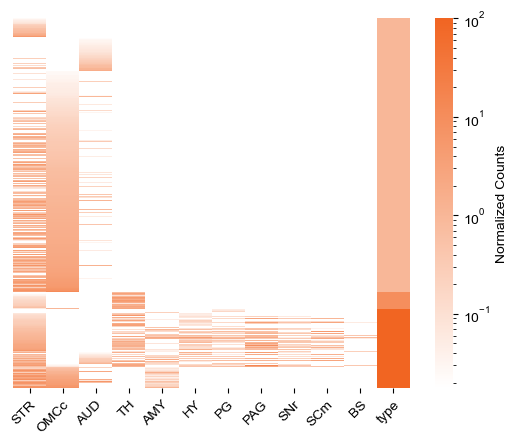

In [28]:
# plot STF6 only, mice[10]
i=10

sort_order = ['type', 'OMCc', 'AUD',  'STR', 'TH', 'AMY', 
              'HY', 'SNr', 'SCm', 'PG', 'PAG',
       'BS']


# counts
plot_df, fig = sorted_heatmap(omc_preprocessN[i][plot_order], sort_by=sort_order, sort_ascend=True, 
                              title="", drop=[], log=True,
                              cbar=True)

# rotate xtick labels 45 degrees
plt.xticks(rotation=45,ha='right', rotation_mode='anchor')

# set cbar label
ax = plt.gca()
ax.collections[0].colorbar.set_label("Normalized Counts")

# plt.savefig(out_path+"OMC_heatmap_mapseq_STF6.svg", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1792433479.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot = plot.replace({"IT":1, "CT":10, "PT":100})


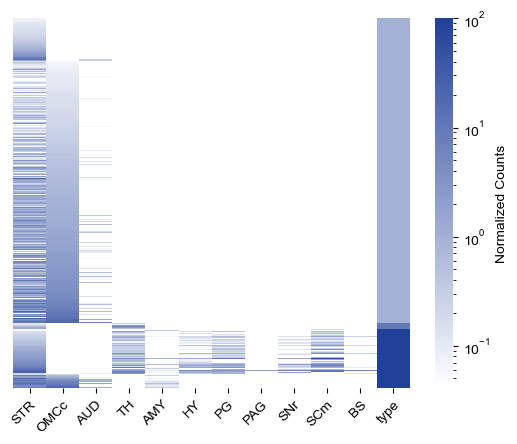

In [29]:
# plot MMM4 only, mice[6]
i=6

# only plot 1000 cells for visualization purposes
n_1000 = omc_preprocessN[6].sample(1000, random_state=10)


plot_df, fig = sorted_heatmap(n_1000[plot_order], sort_by=sort_order, sort_ascend=True, title="",
                              drop=[], cmap=blue_cmp, log=True,
                              cbar=True)


# rotate xtick labels 45 degrees
plt.xticks(rotation=45,ha='right', rotation_mode='anchor')

# set cbar label
ax = plt.gca()
ax.collections[0].colorbar.set_label("Normalized Counts")

# plt.savefig(out_path+"OMC_heatmap_mapseq_MMM4.svg", dpi=300, bbox_inches="tight")
plt.show()


# Seperate barcodes/neurons by cell type
- seperate into IT and PT cells for the following analysis/model comparison
- Normalized counts are normalized for RNA spike-ins and per animal batch effects

In [30]:
# seperate normalized barcode counts into celltypes
it_norm = [df[df["type"]=="IT"].reset_index(drop=True) for df in omc_preprocessN]
pt_norm = [df[df["type"]=="PT"].reset_index(drop=True) for df in omc_preprocessN]

# seperate binarized counts into celltypes
it_bin = [df[df["type"]=="IT"].reset_index(drop=True) for df in omc_type]
pt_bin = [df[df["type"]=="PT"].reset_index(drop=True) for df in omc_type]


# Barcode count per neuron - Testing innervation
Fig. 3c-e

In [31]:
it_areas = ["OMCc", "AUD", "STR"]
pt_areas = ["TH", "HY", "AMY", "PAG", "SNr", "SCm", "PG", "BS"]

In [32]:
# calculate medians
it_med = dfs_to_medians(it_norm, drop=["type"])
# add back cell type
it_med["type"] = "IT"


pt_med = dfs_to_medians(pt_norm, drop=["type"])
pt_med["type"] = "PT"

# drop nan - some areas (BS) don't have any projections in 1 sample
pt_med_n0 = pt_med[pt_med["median"]>0]


/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/2512195334.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])
/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/2512195334.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])


/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


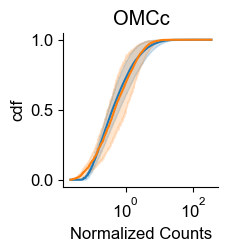

/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


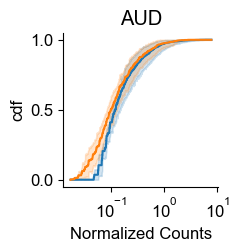

/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


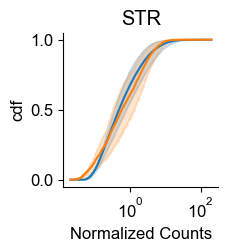

/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


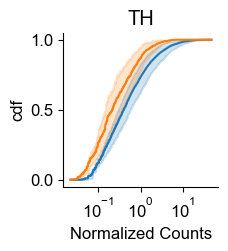

/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


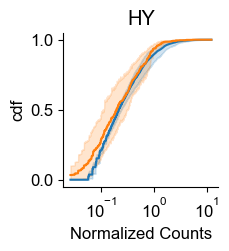

/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


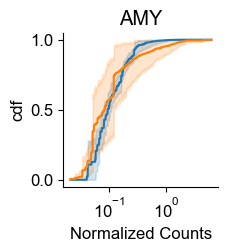

/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


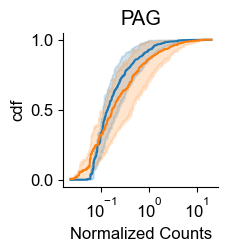

/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


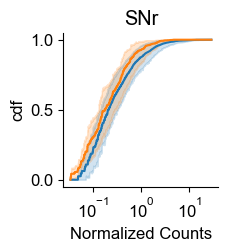

/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


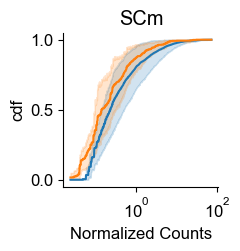

/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


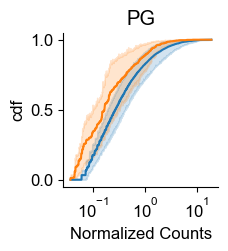

/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1917251269.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


NO BARCODES, cannot compute ECDF for BS STM2


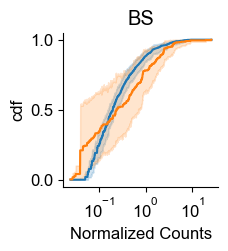

In [38]:
# cdfs - used as each area has many neurons each with a barcode count

# IT areas
for area in it_areas:
    plot_cdf(it_norm, plot_areas=[area], color_by="species",
        title=None, legend=False, individual=False, fig_size=(2,2))
    # plt.savefig(out_path+"cdf_comb_all_med_"+area+"_mean_ci95_all.svg",
    #  dpi=300, bbox_inches="tight")
    plt.show()

# PT areas
for area in pt_areas:
    plot_cdf(pt_norm, plot_areas=[area], color_by="species",
        title=None, legend=False, individual=False, fig_size=(2,2))
    # plt.savefig(out_path+"cdf_comb_all_med_"+area+"_mean_ci95_all.svg",
    #  dpi=300, bbox_inches="tight")
    plt.show()



In [ ]:
# volcano plot - done on median values of barcode count/neuron for each area

# process data into plottable dataframe
# add back 
all_med = pd.concat([it_med, pt_med])
# drop injection site
all_med = all_med[all_med["area"]!="OMCi"]
# drop nan
all_med_n0 = all_med[all_med["median"]>0]

plot = stvmm_calc_ttest(all_med_n0, sp1="MMus", sp2="STeg", 
                        to_plot="median", test="mannwhitneyu")
plot = plot[~((plot["area"]=="AUD") & (plot["type"]=="PT"))]
plot = plot[~((plot["area"]=="OMCc") & (plot["type"]=="PT"))]
plot.reset_index(inplace=True)
plot


,index,area,p-value,MMus_mean,MMus_sem,STeg_mean,STeg_sem,fold_change,log2_fc,nlog10_p,p<0.05,type
0,0,AUD,0.106061,0.130907,0.017218,0.111530,0.019782,0.851978,-0.231112,0.974446,False,IT
1,1,OMCc,0.755051,0.495660,0.118467,0.725393,0.218945,1.463488,0.549411,0.122024,False,IT
2,2,STR,1.000000,0.584737,0.149598,0.847916,0.284759,1.450081,0.536134,-0.000000,False,IT
3,3,AMY,0.755051,0.097490,0.007598,0.115972,0.033100,1.189577,0.250448,0.122024,False,PT
4,5,BS,NaN,0.201749,0.027456,NaN,NaN,NaN,NaN,NaN,False,PT
5,6,HY,0.530303,0.219923,0.013185,0.257028,0.054825,1.168718,0.224927,0.275476,False,PT
6,8,PAG,0.755051,0.164690,0.039466,0.313288,0.120007,1.902290,0.927737,0.122024,False,PT
7,9,PG,0.431818,0.301544,0.074411,0.248056,0.092911,0.822621,-0.281699,0.364699,False,PT
8,10,SCm,0.267677,0.370637,0.139468,0.239036,0.064834,0.644932,-0.632780,0.572389,False,PT
9,11,SNr,0.755051,0.242874,0.056947,0.238041,0.073735,0.980102,-0.028997,0.122024,False,PT


,index,area,p-value,MMus_mean,MMus_sem,STeg_mean,STeg_sem,fold_change,log2_fc,nlog10_p,p<0.05,type
0,0,AUD,0.106061,0.130907,0.017218,0.111530,0.019782,0.851978,-0.231112,0.974446,False,IT
1,1,OMCc,0.755051,0.495660,0.118467,0.725393,0.218945,1.463488,0.549411,0.122024,False,IT
2,2,STR,1.000000,0.584737,0.149598,0.847916,0.284759,1.450081,0.536134,-0.000000,False,IT
3,3,AMY,0.755051,0.097490,0.007598,0.115972,0.033100,1.189577,0.250448,0.122024,False,PT
4,5,BS,NaN,0.201749,0.027456,NaN,NaN,NaN,NaN,NaN,False,PT
5,6,HY,0.530303,0.219923,0.013185,0.257028,0.054825,1.168718,0.224927,0.275476,False,PT
6,8,PAG,0.755051,0.164690,0.039466,0.313288,0.120007,1.902290,0.927737,0.122024,False,PT
7,9,PG,0.431818,0.301544,0.074411,0.248056,0.092911,0.822621,-0.281699,0.364699,False,PT
8,10,SCm,0.267677,0.370637,0.139468,0.239036,0.064834,0.644932,-0.632780,0.572389,False,PT
9,11,SNr,0.755051,0.242874,0.056947,0.238041,0.073735,0.980102,-0.028997,0.122024,False,PT


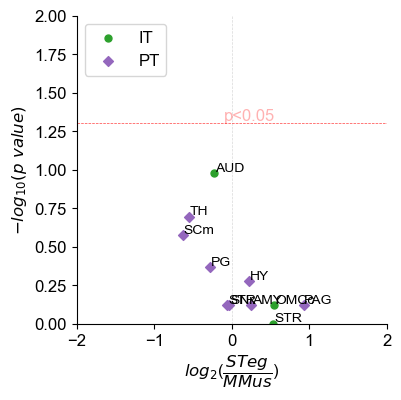

In [ ]:
display(plot)
plot_volcano(plot[plot["area"]!="BS"].reset_index(drop=True), p_01=False, shape="type", title="", 
             xlim=(-2,2),  ylim=(0, -np.log10(0.01)))

# plt.savefig(out_path+"volcano_comb_inj_med_celltypes.svg", dpi=300, bbox_inches="tight")
plt.show()

In [40]:
# Significance testing

print("\nIT")
display(statistic_testing(all_med_n0[all_med_n0["type"]=="IT"], to_plot="median", test="mannwhitneyu"))

print("\nPT")
display(statistic_testing(all_med_n0[all_med_n0["type"]=="PT"], to_plot="median", test="mannwhitneyu"))



IT


NameError: name 'all_med_n0' is not defined

# Proportion
- proportion calculated within cell type

In [34]:
it_prop = dfs_to_proportions(it_bin, cell_type="IT", drop=["OMCi", "type"])
pt_prop = dfs_to_proportions(pt_bin, cell_type="PT", drop=["OMCi", "type"])


/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1941326770.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])
/var/folders/p6/sybd66w15k9_sz65dtgk6hym0000gp/T/ipykernel_62057/1941326770.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])


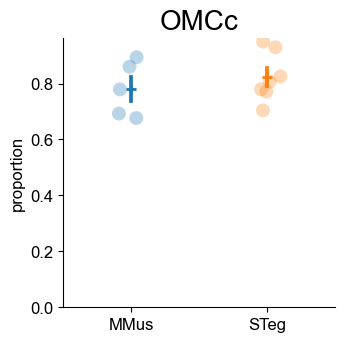

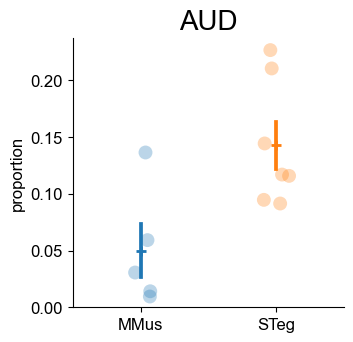

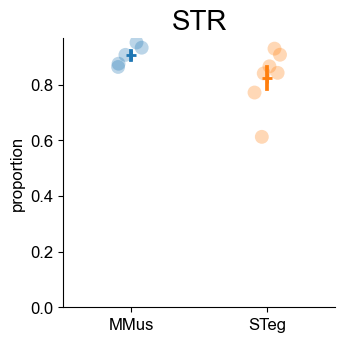

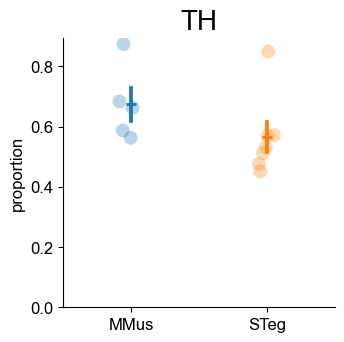

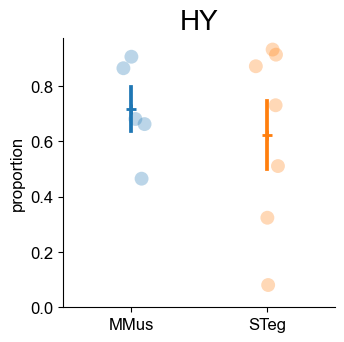

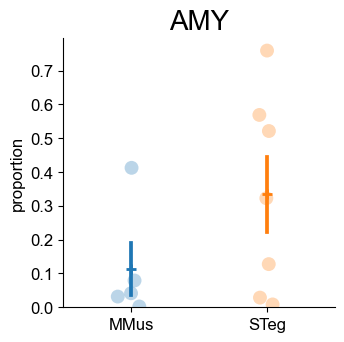

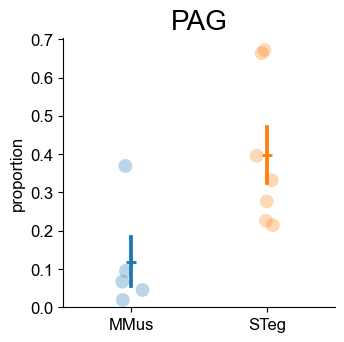

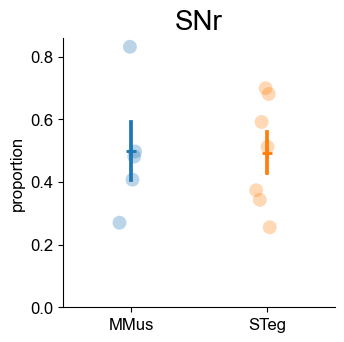

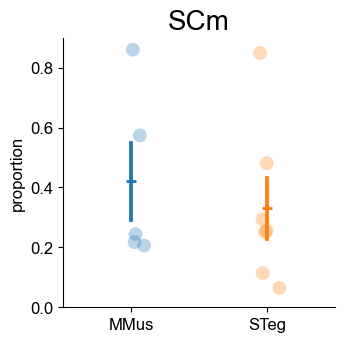

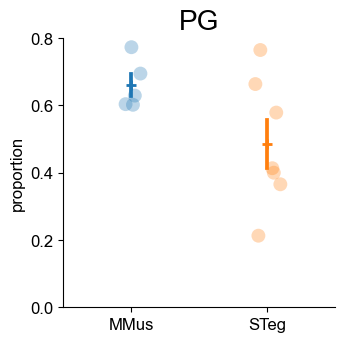

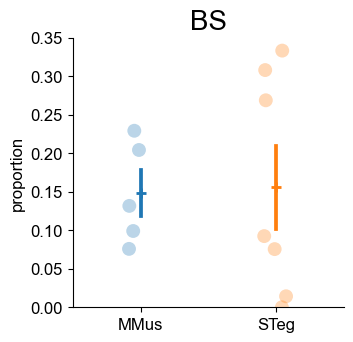

In [39]:
# plot it areas
for area in it_areas:
    dot_plot(it_prop, subset=["area",area], title=area, add_legend=False,
             jitter=True)
    # plt.savefig(out_path+"OMC_"+area+"_proportion_dot.svg", dpi=300, bbox_inches="tight")
    plt.show()

# plot pt areas
for area in pt_areas:
    dot_plot(pt_prop, subset=["area",area], title=area, add_legend=False,
             jitter=True)
    # plt.savefig(out_path+"OMC_"+area+"_proportion_dot.svg", dpi=300, bbox_inches="tight")
    plt.show()



In [36]:
it_prop["type"] = "IT"
pt_prop["type"] = "PT"
omc_prop = pd.concat([it_prop, pt_prop])



MANNWHITNEYU


,area,p-value,MMus_mean,MMus_sem,STeg_mean,STeg_sem,fold_change,log2_fc,nlog10_p,p<0.05
0,AMY,0.267677,0.113423,0.075764,0.333813,0.110531,2.943087,1.557330,0.572389,False
1,AUD,0.030303,0.050002,0.023315,0.143009,0.020696,2.860087,1.516059,1.518514,True
2,BS,0.876263,0.148019,0.029696,0.156069,0.053946,1.054388,0.076406,0.057366,False
3,HY,1.000000,0.716386,0.079205,0.623762,0.124478,0.870707,-0.199740,-0.000000,False
4,OMCc,0.431818,0.780523,0.043465,0.823807,0.033262,1.055454,0.077864,0.364699,False
5,PAG,0.030303,0.119106,0.063729,0.397023,0.073663,3.333369,1.736981,1.518514,True
6,PG,0.106061,0.660502,0.032763,0.485515,0.072310,0.735070,-0.444046,0.974446,False
7,SCm,0.876263,0.420469,0.129390,0.329837,0.100260,0.784452,-0.350244,0.057366,False
8,SNr,1.000000,0.497362,0.092619,0.493500,0.065661,0.992236,-0.011245,-0.000000,False
9,STR,0.106061,0.905569,0.016619,0.823819,0.040202,0.909725,-0.136498,0.974446,False


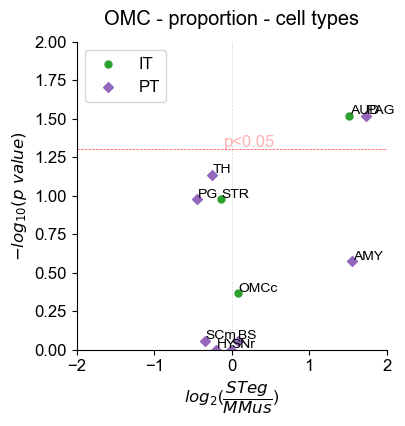

In [37]:
# volcano plot - done on median values of barcode count/neuron for each area

plot = stvmm_calc_ttest(omc_prop, sp1="MMus", sp2="STeg", test="mannwhitneyu")


print("\nMANNWHITNEYU")
mannwhitney = statistic_testing(omc_prop, test="mannwhitneyu")
display(mannwhitney)

plot_volcano(plot, p_01=False, shape="type", title="OMC - proportion - cell types", 
             xlim=(-2,2),  ylim=(0, -np.log10(0.01)))

# plt.savefig(out_path+"volcano_comb_inj_prop_celltypes.svg", dpi=300, bbox_inches="tight")
plt.show()